## PAIR TRADING USING CLUSTERING

### Pairs trading is a non-directional, relative value investment strategy that seeks to identify 2 companies or funds with similar characteristics whose equity securities are currently trading at a price relationship that is out of their historical trading range. This investment strategy will entail buying the undervalued security while short-selling the overvalued security, all while maintaining market neutrality.

### Pairs trading refers to trading a discrepancy in the correlation of two underlyings. For example, if XYZ is positively correlated to ZYX, and one is up 10 points while the other is down 10 points, we can assume that they will revert back to their positive correlation. There are many pairs out there, but we have a few guidelines we like to stick to.

### Trade example: /ES and /NQ are highly correlated stock index futures. If there was a situation where /ES was up 1% but /NQ was flat, we might look to sell /ES while buying /NQ. The assumption in this trade is that the correlation breakdown between the pair is temporary and the movements would normalize.

Here, taking Q500US as the dataset, I am trying to find the pairs for trading using DBSCAN clustering algorithm

# Import libraries

In [242]:
# data manipulation and plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
# Model training and feature engineering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint

from scipy import stats
# quantopian libraries
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

#### Study date is provided as the end date for the dataset. Study date is going to be the last date for the dataset to be used in the model.
##### Here date is chosen to be 25th May, to study the effect of COVID-19 on the pairs

In [243]:
study_date = "2020-5-25"

### In this project, Q500US universe is selected which contains US's top 500 companies for equity

In [244]:
universe = Q500US()

#### Pipeline is created which will fetch the Market Cap details and Financial Health details for all the 500 Companies that we imported from Q500US.

In [245]:
pipe = Pipeline(
    columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'Financial Health': morningstar.asset_classification.financial_health_grade.latest
    },
    screen=universe
)

In [246]:
res = run_pipeline(pipe, study_date, study_date)
res.index = res.index.droplevel(0)

In [247]:
res.head(10)

,Financial Health,Market Cap
Equity(2 [HWM]),C,4
Equity(24 [AAPL]),A,4
Equity(53 [ABMD]),A,4
Equity(62 [ABT]),A,4
Equity(67 [ADSK]),A,4
Equity(76 [TAP]),C,4
Equity(114 [ADBE]),A,4
Equity(122 [ADI]),B,4
Equity(128 [ADM]),B,4
Equity(161 [AEP]),B,4


In [248]:
res["Financial Health"].value_counts()

B    179
C    153
A    126
D     36
F      4
Name: Financial Health, dtype: int64

In [249]:
res['Financial Health'] = res['Financial Health'].astype('object')
health_dict = {u'A': 0.2,
               u'B': 0.4,
               u'C': 0.6,
               u'D': 0.8,
               u'F': 1.0}
res = res.replace({'Financial Health': health_dict})

In [250]:
res.describe()

,Financial Health,Market Cap
count,498.000000,498.000000
mean,0.444578,3.939759
std,0.186950,0.254508
min,0.200000,2.000000
25%,0.200000,4.000000
50%,0.400000,4.000000
75%,0.600000,4.000000
max,1.000000,4.000000


Dataset is containing data from last 2 years which entails the infamous March 20 to May 20 COVID season. 

In [251]:
pricing = get_pricing(
    symbols=res.index,
    fields='close_price',
    start_date=pd.Timestamp(study_date) - pd.DateOffset(months=24),
    end_date=pd.Timestamp(study_date)
)

In [252]:
pricing

,Equity(2 [HWM]),Equity(24 [AAPL]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(114 [ADBE]),Equity(122 [ADI]),Equity(128 [ADM]),Equity(161 [AEP]),...,Equity(53089 [PINS]),Equity(53095 [ZM]),Equity(53116 [BYND]),Equity(53158 [UBER]),Equity(53196 [CTVA]),Equity(53248 [CRWD]),Equity(53256 [CHWY]),Equity(53271 [WORK]),Equity(53511 [DDOG]),Equity(53535 [PTON])
2018-05-25 00:00:00+00:00,18.218,183.562,394.070,60.317,132.750,57.441,243.460,91.637,41.682,62.987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-29 00:00:00+00:00,17.714,182.861,387.530,59.272,129.630,57.553,242.120,90.629,40.962,63.361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-30 00:00:00+00:00,17.907,182.501,388.570,60.036,129.360,58.301,247.410,91.186,41.439,63.717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31 00:00:00+00:00,17.438,181.907,381.170,59.514,129.100,57.647,249.280,93.298,40.905,63.652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 00:00:00+00:00,17.547,185.187,392.170,60.346,133.600,57.995,251.310,94.479,41.008,62.471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-04 00:00:00+00:00,17.532,186.706,405.910,60.945,135.580,57.788,253.330,95.996,41.242,61.881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-05 00:00:00+00:00,17.507,188.166,405.360,60.945,136.810,57.515,252.750,96.668,41.383,61.178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-06 00:00:00+00:00,17.724,188.906,410.270,61.458,137.940,58.165,254.070,98.031,41.897,59.764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-07 00:00:00+00:00,17.744,188.331,405.620,61.090,134.140,58.946,247.530,98.359,41.822,60.092,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-08 00:00:00+00:00,17.705,186.385,409.770,61.197,135.130,59.831,251.200,97.491,41.953,60.063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We are going to fit our clustering model on Percentage changes of the daily prices.

In [253]:
returns = pricing.pct_change()

In [254]:
returns

,Equity(2 [HWM]),Equity(24 [AAPL]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(114 [ADBE]),Equity(122 [ADI]),Equity(128 [ADM]),Equity(161 [AEP]),...,Equity(53089 [PINS]),Equity(53095 [ZM]),Equity(53116 [BYND]),Equity(53158 [UBER]),Equity(53196 [CTVA]),Equity(53248 [CRWD]),Equity(53256 [CHWY]),Equity(53271 [WORK]),Equity(53511 [DDOG]),Equity(53535 [PTON])
2018-05-25 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-29 00:00:00+00:00,-0.027665,-0.003819,-0.016596,-0.017325,-0.023503,0.001950,-0.005504,-0.011000,-0.017274,0.005938,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-30 00:00:00+00:00,0.010895,-0.001969,0.002684,0.012890,-0.002083,0.012997,0.021849,0.006146,0.011645,0.005619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31 00:00:00+00:00,-0.026191,-0.003255,-0.019044,-0.008695,-0.002010,-0.011218,0.007558,0.023161,-0.012886,-0.001020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 00:00:00+00:00,0.006251,0.018031,0.028859,0.013980,0.034857,0.006037,0.008143,0.012658,0.002518,-0.018554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-04 00:00:00+00:00,-0.000855,0.008203,0.035036,0.009926,0.014820,-0.003569,0.008038,0.016056,0.005706,-0.009444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-05 00:00:00+00:00,-0.001426,0.007820,-0.001355,0.000000,0.009072,-0.004724,-0.002290,0.007000,0.003419,-0.011361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-06 00:00:00+00:00,0.012395,0.003933,0.012113,0.008417,0.008260,0.011301,0.005223,0.014100,0.012421,-0.023113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-07 00:00:00+00:00,0.001128,-0.003044,-0.011334,-0.005988,-0.027548,0.013427,-0.025741,0.003346,-0.001790,0.005488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-08 00:00:00+00:00,-0.002198,-0.010333,0.010231,0.001752,0.007380,0.015014,0.014826,-0.008825,0.003132,-0.000483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Sample Plot

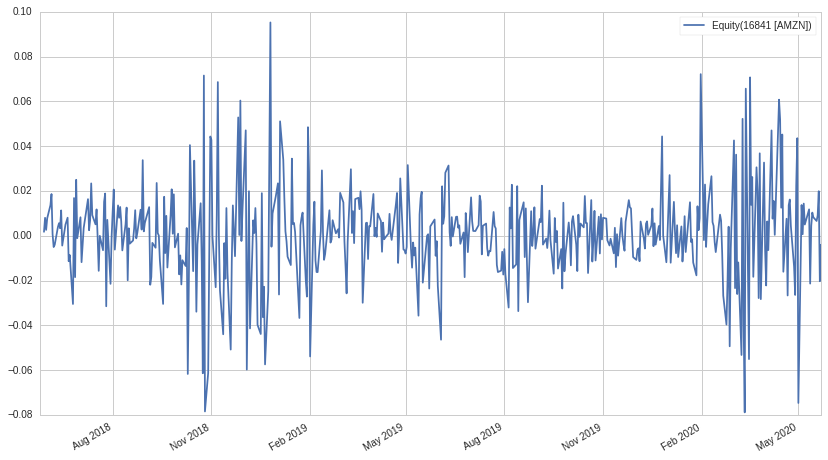

In [255]:
returns[symbols(['AMZN'])].plot();

#### Drop all null values columns

In [256]:
returns = returns.iloc[1:,:].dropna(axis=1)

In [257]:
returns

,Equity(2 [HWM]),Equity(24 [AAPL]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(114 [ADBE]),Equity(122 [ADI]),Equity(128 [ADM]),Equity(161 [AEP]),...,Equity(50860 [VST]),Equity(50970 [ATUS]),Equity(51231 [ROKU]),Equity(51314 [MDB]),Equity(51689 [PAGS]),Equity(51734 [VICI]),Equity(51832 [ZS]),Equity(51854 [DBX]),Equity(51895 [SPOT]),Equity(51937 [DOCU])
2018-05-29 00:00:00+00:00,-0.027665,-0.003819,-0.016596,-0.017325,-0.023503,0.001950,-0.005504,-0.011000,-0.017274,0.005938,...,0.002321,0.023850,0.001479,0.018228,-0.100847,0.004563,0.028056,-0.006676,-0.012518,0.044454
2018-05-30 00:00:00+00:00,0.010895,-0.001969,0.002684,0.012890,-0.002083,0.012997,0.021849,0.006146,0.011645,0.005619,...,0.011235,0.022706,-0.003291,0.013355,0.057493,0.000224,-0.005458,0.024194,0.011448,0.033471
2018-05-31 00:00:00+00:00,-0.026191,-0.003255,-0.019044,-0.008695,-0.002010,-0.011218,0.007558,0.023161,-0.012886,-0.001020,...,0.010304,0.010871,-0.026001,0.016178,-0.011289,-0.028817,0.029400,-0.015748,0.008537,-0.004598
2018-06-01 00:00:00+00:00,0.006251,0.018031,0.028859,0.013980,0.034857,0.006037,0.008143,0.012658,0.002518,-0.018554,...,-0.007345,0.025548,-0.010144,-0.012948,0.035817,0.025804,0.071592,-0.011333,0.010177,0.007030
2018-06-04 00:00:00+00:00,-0.000855,0.008203,0.035036,0.009926,0.014820,-0.003569,0.008038,0.016056,0.005706,-0.009444,...,-0.003721,-0.005493,0.025351,0.036344,-0.009921,0.024648,0.037669,0.010452,0.022031,0.069206
2018-06-05 00:00:00+00:00,-0.001426,0.007820,-0.001355,0.000000,0.009072,-0.004724,-0.002290,0.007000,0.003419,-0.011361,...,0.006196,-0.031074,0.059600,0.021789,-0.037797,-0.013730,0.031507,0.030030,0.013143,0.019772
2018-06-06 00:00:00+00:00,0.012395,0.003933,0.012113,0.008417,0.008260,0.011301,0.005223,0.014100,0.012421,-0.023113,...,0.008225,0.037252,-0.021248,0.040617,0.011876,-0.005457,0.016600,0.011338,0.002970,0.048290
2018-06-07 00:00:00+00:00,0.001128,-0.003044,-0.011334,-0.005988,-0.027548,0.013427,-0.025741,0.003346,-0.001790,0.005488,...,0.002845,-0.016930,0.003297,-0.032787,-0.102016,0.001512,0.234487,-0.030429,0.002901,-0.022858
2018-06-08 00:00:00+00:00,-0.002198,-0.010333,0.010231,0.001752,0.007380,0.015014,0.014826,-0.008825,0.003132,-0.000483,...,-0.004464,0.004517,-0.008089,0.047417,0.033512,0.021971,0.073016,-0.009250,0.032421,0.034821
2018-06-11 00:00:00+00:00,0.013951,-0.001202,0.020646,-0.002369,0.006216,0.016814,-0.000876,0.003364,0.014945,-0.018547,...,-0.019150,0.009556,0.056575,0.037565,0.031128,0.003392,0.016765,0.004168,0.006829,0.027437


#### Dimension Reduction(PCA)

In [258]:
N_PRIN_COMPONENTS = 30
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


PCA(copy=True, n_components=30, whiten=False)

In [259]:
pca.components_.T.shape

(464, 30)

In [260]:
X = np.hstack(
    (pca.components_.T,
     res['Market Cap'][returns.columns].values[:, np.newaxis],
     res['Financial Health'][returns.columns].values[:, np.newaxis])
)

In [261]:
X

array([[ 0.06241009, -0.06387995,  0.03390788, ..., -0.0503073 ,
         4.        ,  0.6       ],
       [ 0.04331508,  0.04678528, -0.00864126, ..., -0.01553047,
         4.        ,  0.2       ],
       [ 0.03079092,  0.05162378, -0.04358632, ..., -0.14267035,
         4.        ,  0.2       ],
       ..., 
       [ 0.03785503,  0.04738365, -0.05451156, ...,  0.14200329,
         4.        ,  0.4       ],
       [ 0.0325613 ,  0.03446391, -0.06207969, ..., -0.07099763,
         4.        ,  0.2       ],
       [ 0.03254009,  0.07485001, -0.0766758 , ...,  0.00456614,
         4.        ,  0.2       ]])

In [262]:
X = preprocessing.StandardScaler().fit_transform(X)

## Clustering Model

In [263]:
clf = DBSCAN(eps=2, min_samples=3)
print clf

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print "\nClusters discovered: %d" % n_clusters_

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

Clusters discovered: 5


/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


# Cluster Analysis

In [264]:
clustered

array([-1,  0, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  4, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  3, -1, -1, -1,  2, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,
       -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  2, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [265]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [266]:
clustered_series

Equity(24 [AAPL])         0
Equity(161 [AEP])         1
Equity(700 [BAC])         4
Equity(1385 [CDNS])       3
Equity(1582 [CL])         2
Equity(1665 [CMS])        1
Equity(2351 [DUK])        1
Equity(2637 [ETR])        1
Equity(2968 [NEE])        1
Equity(5061 [MSFT])       0
Equity(5310 [NI])         1
Equity(5885 [PEP])        2
Equity(5938 [PG])         2
Equity(6994 [SNPS])       3
Equity(17850 [FE])        1
Equity(20088 [GS])        4
Equity(21964 [XEL])       1
Equity(22802 [MDLZ])      2
Equity(24783 [AEE])       1
Equity(25006 [JPM])       4
Equity(26578 [GOOG_L])    0
Equity(32146 [MA])        3
Equity(35920 [V])         3
Equity(36098 [AWK])       1
dtype: int64

In [267]:
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1)]
print(ticker_count_reduced)
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()


1    10
3     4
2     4
4     3
0     3
dtype: int64
Clusters formed: 5
Pairs to evaluate: 126


In [268]:
X_tsne = TSNE(learning_rate=1000, perplexity=25).fit_transform(X)

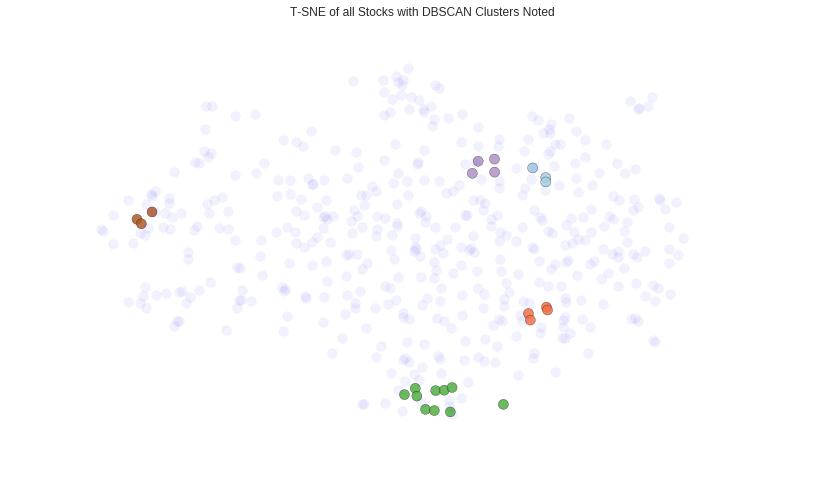

In [269]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

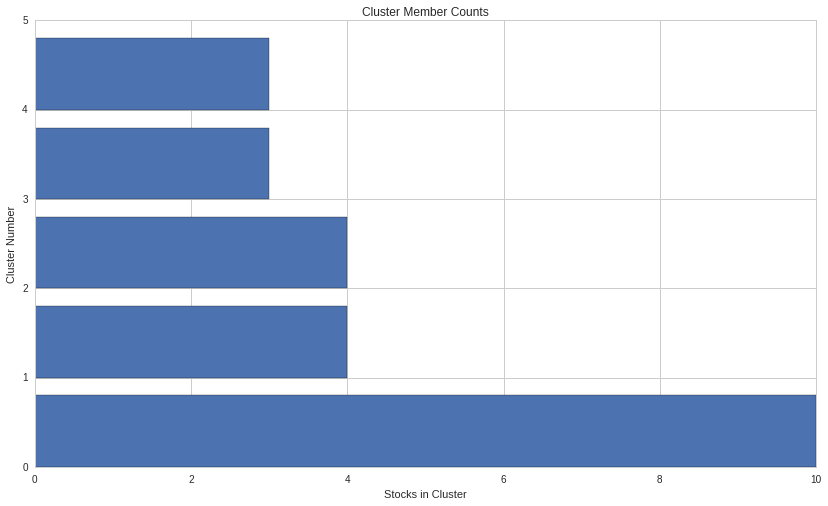

In [270]:
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

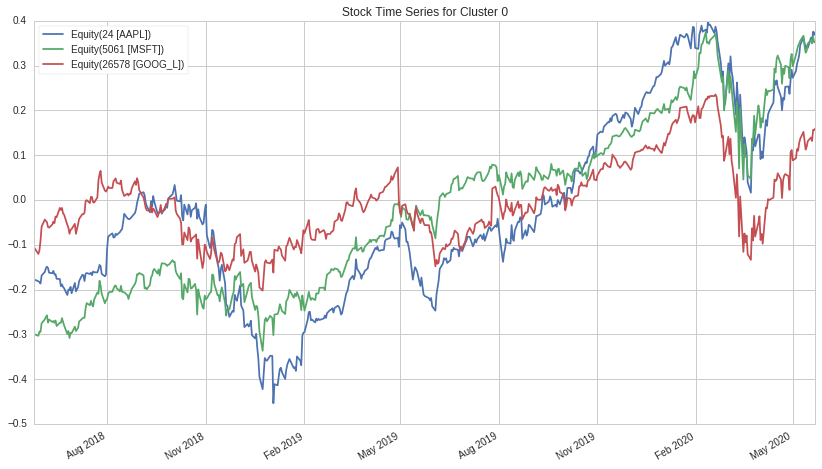

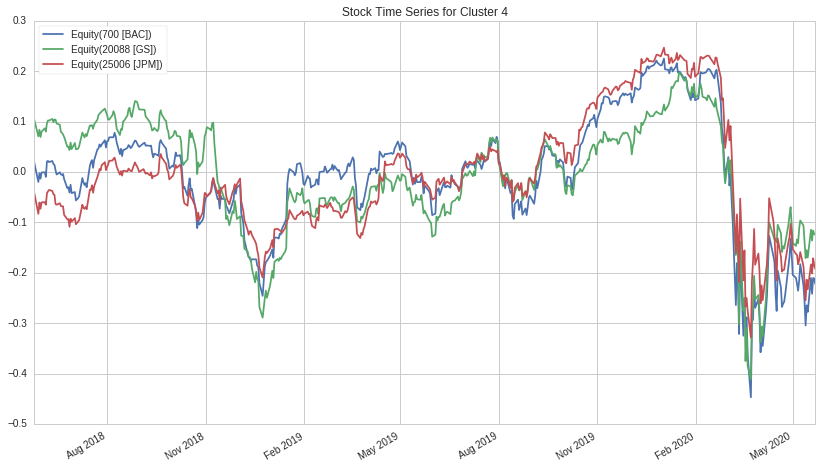

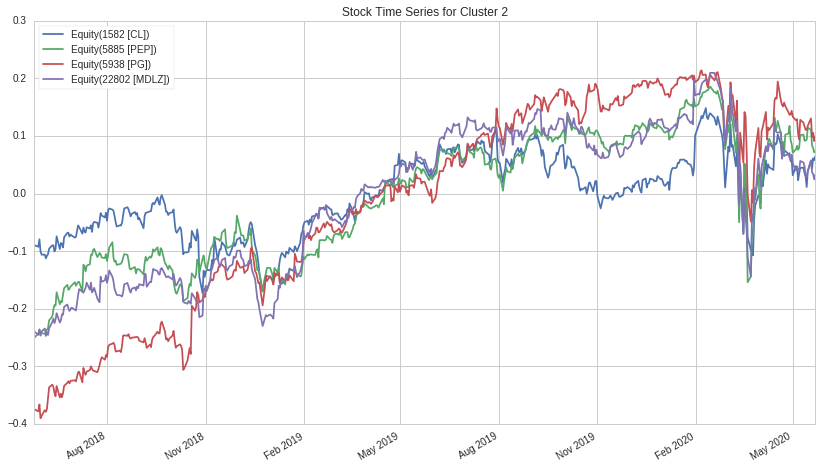

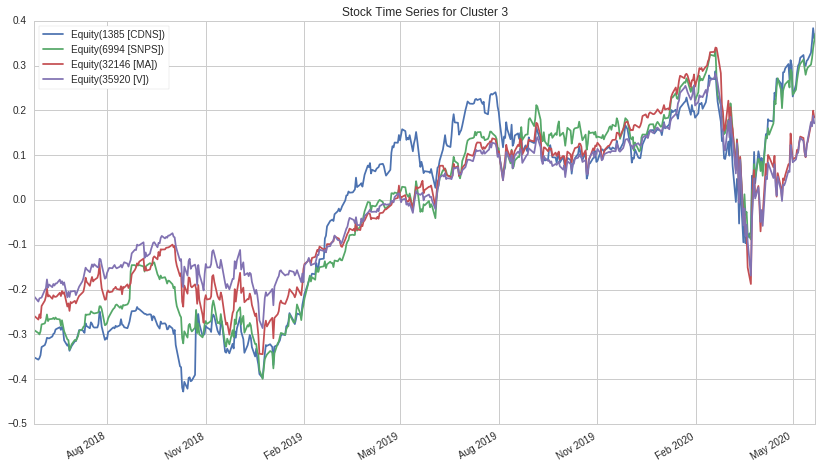

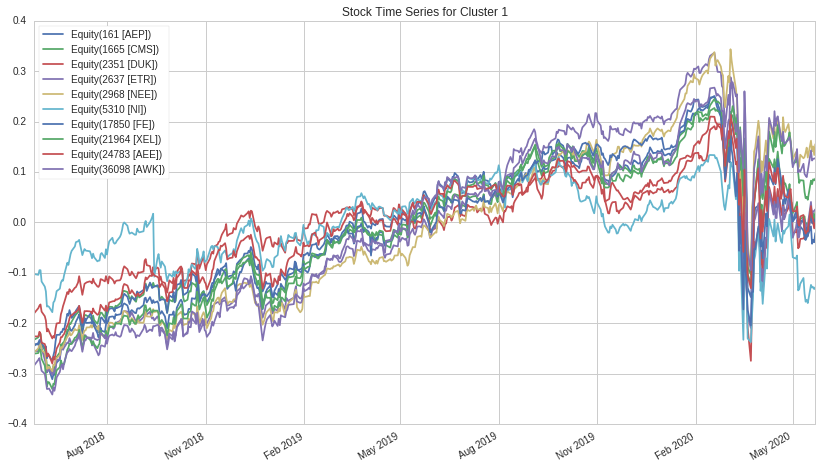

In [271]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 13)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(pricing[tickers].mean())
    data = np.log(pricing[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

In [272]:
which_cluster = clustered_series.loc[symbols('AAPL')]
clustered_series[clustered_series == which_cluster]

Equity(24 [AAPL])         0
Equity(5061 [MSFT])       0
Equity(26578 [GOOG_L])    0
dtype: int64

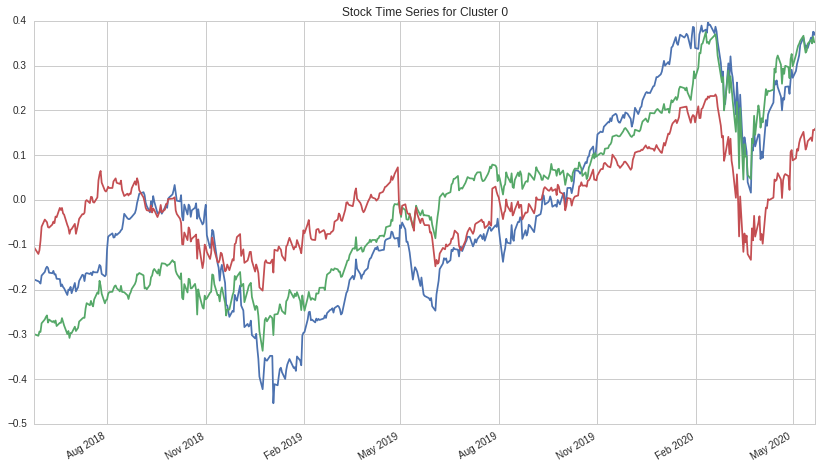

In [273]:
tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(pricing[tickers].mean())
data = np.log(pricing[tickers]).sub(means)
data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster);

The most common test for Pairs Trading is the cointegration test. Cointegration is a statistical property of two or more time-series variables which indicates if a linear combination of the variables is stationary.

Let us understand this statement above. The two-time series variables, in this case, are the log of prices of stocks A and B. Linear combination of these variables can be a linear equation defining the spread:

As you know, Spread = log(a) – nlog(b), where ‘a’ and ‘b’ are prices of stocks A and B respectively.

For each stock of A bought, you have sold n stocks of B.

If A and B are cointegrated then it implies that this equation above is stationary. A stationary process has very valuable features which are required to model Pairs Trading strategies. For instance, in this case, if the equation above is stationary, that suggests that the mean and variance of this equation remains constant over time. So if we start with ‘n’, which is called the hedge ratio, so that spread = 0, the property of stationary implies that the expected value of spread will remain as 0. Any deviation from this expected value is a case for statistical abnormality, hence a case for pairs trading!

In [274]:
def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [275]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        pricing[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [276]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [277]:
pairs

[(Equity(161 [AEP]), Equity(2637 [ETR])),
 (Equity(161 [AEP]), Equity(17850 [FE])),
 (Equity(161 [AEP]), Equity(24783 [AEE])),
 (Equity(1665 [CMS]), Equity(2637 [ETR])),
 (Equity(1665 [CMS]), Equity(17850 [FE])),
 (Equity(1665 [CMS]), Equity(24783 [AEE])),
 (Equity(2351 [DUK]), Equity(2637 [ETR])),
 (Equity(2637 [ETR]), Equity(17850 [FE])),
 (Equity(21964 [XEL]), Equity(24783 [AEE])),
 (Equity(21964 [XEL]), Equity(36098 [AWK])),
 (Equity(24783 [AEE]), Equity(36098 [AWK])),
 (Equity(1582 [CL]), Equity(5885 [PEP])),
 (Equity(1582 [CL]), Equity(5938 [PG])),
 (Equity(1582 [CL]), Equity(22802 [MDLZ])),
 (Equity(5885 [PEP]), Equity(5938 [PG])),
 (Equity(5885 [PEP]), Equity(22802 [MDLZ])),
 (Equity(32146 [MA]), Equity(35920 [V]))]

In [278]:
print "We found %d pairs." % len(pairs)

We found 17 pairs.


In [279]:
print "In those pairs, there are %d unique tickers." % len(np.unique(pairs))

In those pairs, there are 14 unique tickers.


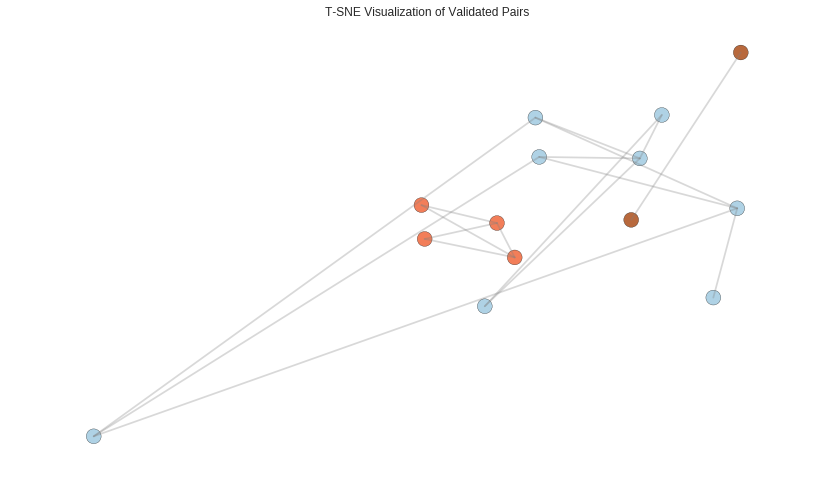

In [280]:
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=returns.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0].symbol
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    ticker2 = pair[0].symbol
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
        
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=[in_pairs_series.values], cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');

# Sample print

## Here to show the pair, both the stocks in the pair is plotted wrt time

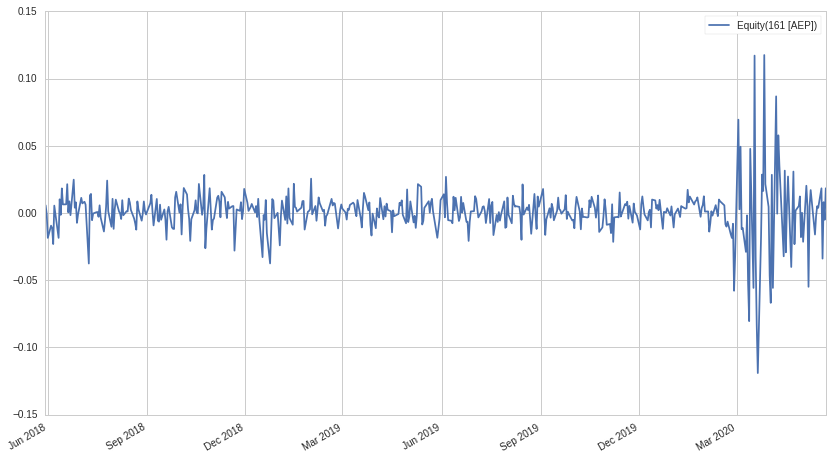

In [281]:
returns[symbols([pairs[0][0]])].plot();

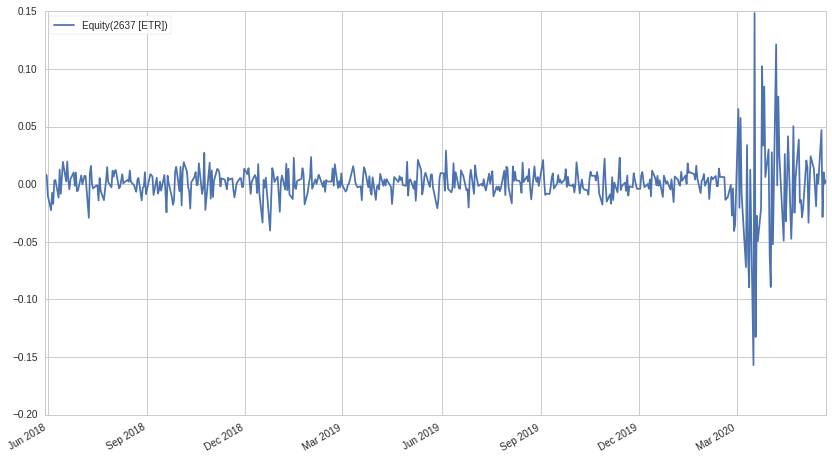

In [282]:
returns[symbols([pairs[0][1]])].plot();

Both of the plots above seems very identical in terms of movement wrt time in the last 2 years.